# Tutorial 7 - Command-line interface



```
      _
    /|_|\   
   / / \ \  
  /_/   \_\  
  \ \   / /  
   \ \_/ /  
    \|_|/  

```
SOPRANO: a Python library for generation, manipulation and analysis of large batches of crystalline structures


*Developed within the CCP-NC project. Copyright STFC 2022*


In [1]:
# This library is useful for displaying the results of the CLI in this notebook.
import pandas as pd
from IPython.display import Image

# We will need a temporary directory to store the output files.
!mkdir -p _temp_output

/home/jks/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In this tutorial we cover some of capabilities of the Soprano command-line interface (CLI).

The CLI is a simple wrapper around the Soprano Python library, which allows to perform some of the most common tasks without having to write any Python code.

You can always get help on the CLI by running `soprano --help` or `soprano <command> --help` (where you can replace `<command>` with any of the commands listed below).

The CLI is still under development and more commands will be added in the future. If you have any suggestions, please get in touch with us!

In [2]:
!soprano --help

Usage: soprano [OPTIONS] COMMAND [ARGS]...

  A CLI tool to streamline common soprano tasks. It has various  subcommands,
  each of which has its own set of options and help.

Options:
  -v, --verbosity LVL  Either CRITICAL, ERROR, WARNING, INFO or DEBUG
  --help               Show this message and exit.

Commands:
  dipolar    Extract and summarise dipolar couplings from structure files.
  nmr        Extract and analyse NMR data from magres file(s).
  plotnmr    Plot the NMR spectrum from a .magres file.
  splitmols  Extract all molecules in a molecular crystal (in any...
  view       Visualise the structure(s) in the given file(s) using the...

      Author: J. Kane Shenton (kane.shenton@stfc.ac.uk)

      Last updated: June 21, 2023


## 1. Extracting NMR data from a .magres file

The Soprano `nmr` command allows to extract NMR data from a .magres file. The command is very simple to use:

```bash
soprano nmr <magres_file >
```

By default this will output a summary table with all of the magnetic shielding and electric field gradient information in the file. 




Chemical shielding columns will include:

- shielding
- shift (if a reference has been specified)
- anisotropy
- reduced_anisotropy
- asymmetry
- span
- skew
- euler angles



and EFG columns will include:

- Vzz
- Quadrupolar_constant
- asymmetry
- euler angles
- NQR transitions

You can include/exclude columns using the `--include` and `--exclude` options.


By default, we reduce to the unique sites in the system. This is done either by looking at the CIF labels (if present) or by symmetry analysis. You can disable this behaviour using the `--no-reduce` option.

If sites have been combined, the output will also include the `multiplicity` column, which indicates how many 'duplicates' of the site are present in the system.

### Filtering and selecting atoms

One of the useful features of the CLI is to quickly filter and summarise the information you're interested in. You can do this across multiple .magres files at the same time, if you wish. 

For example, we can use the `-s` option to filter the output by site label or species: 

```bash
soprano nmr <magres_file > -s C
```

will only output the NMR data for the carbon atoms.

If you have CIF-style labels in your .magres file, you can specify these using the same `-s` option:

```bash
soprano nmr <magres_file > -s C1,H1a,H1b
```

Notice that we also combined multiple selections, separated by commas.

If you don't have CIF-style labels, you can add a `.` to the label and give an index (e.g. `C.1` to get the first C atom in the file). You can also use a range to get multiple atoms at the same time (e.g. `C.1-3` to get the first three C atoms in the file).

**Querying properties**:

You can also use the pandas query syntax to filter the output. For example, to get all the C atoms with a chemical shielding larger than 120 ppm:

```bash
soprano nmr <magres_file > -s C --query 'MS_shielding > 120'
```

You can build up quite complex queries in this way. For example, to search through all the .magres files in the current directory and get all the C atoms with a chemical shielding between 100 and 200 ppm and an asymmetry greater than 0.5:

```bash
soprano nmr *.magres -s C --query "100 < MS_shielding < 200 and MS_asymmetry > 0.5"
```

In [3]:
!soprano nmr \
    ../tests/test_data/*.magres \
    -s C \
    --query "100 < MS_shielding < 200 and MS_asymmetry > 0.5" \
    --include MS_shielding,MS_asymmetry \
    --merge \
    -o ./_temp_output/query_results.csv

df = pd.read_csv('_temp_output/query_results.csv')
df.iloc[:,1:]

error: Could not select atoms based on selection string: Element C not present in the atoms object


,labels,species,multiplicity,tags,file,MS_shielding/ppm,MS_asymmetry
0,C4,13C,4,22,../tests/test_data/EDIZUM.magres,179.428756,0.872576
1,C7,13C,4,25,../tests/test_data/EDIZUM.magres,130.068841,0.515770
2,C9,13C,4,27,../tests/test_data/EDIZUM.magres,184.179198,0.976923
3,C_1,13C,1,6,../tests/test_data/ethanol.magres,156.467218,0.704557


Note that we got an error for the magres file that did not contain a C atom, but the C atoms in the other files were processed correctly.

### Averaging over functional groups

In organic systems, we often have functional groups that we want to average over. For example, we might want to average over all the methyl groups in a molecule. The CLI allows to do this using the `-g` option:

```bash
soprano nmr <magres_file > -g CH3
```

You can also comma-separate multiple groups:

```bash
soprano nmr <magres_file > -g CH3,NH3
```

The output will contain the average NMR data for each group. For example, for ethanol, we get:

In [4]:
!soprano nmr ./tutorial_data/ethanol.magres \
    -g CH3 \
    --include MS_shielding,MS_asymmetry,MS_reduced_anisotropy \
    -o ./_temp_output/ethanol_CH3.csv

# Show the results:
df = pd.read_csv('_temp_output/ethanol_CH3.csv')
# drop the column called 'file'
df = df.drop('file', axis=1)
# drop unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df

,labels,species,multiplicity,tags,MS_shielding/ppm,MS_reduced_anisotropy/ppm,MS_asymmetry
0,"H_1,H_2,H_3",1H,3,-100000,29.983808,-1.046125,0.541664
1,H_4,1H,1,3,26.980027,5.444059,0.937102
2,H_5,1H,1,4,27.390413,-4.747813,0.928356
3,H_6,1H,1,5,31.984976,9.412286,0.452687
4,C_1,13C,1,6,156.467218,22.531358,0.704557
5,C_2,13C,1,7,109.857140,46.834011,0.414376
6,O_1,17O,1,8,268.028520,-34.253562,0.983015


### Other options
- Viewing the (filtered) structure (`--view`) using the ASE GUI
- Saving the output to a file (`-o`) (txt, CSV, JSON, YAML, etc.)
- Setting the isotopes (`-i`) (e.g. `-i 13C,2H`)
- Setting the chemical shift gradients and references (e.g. `--gradients C:-0.99,H:-0.95` and `--references C:100,H:30`)
- Merging the results from multiple files (`--merge`)
- Sorting the output by any column (e.g. `--sortby EFG_Vzz`) 
- Setting the Euler angle convention (e.g. `--euler zyz`)

To see the full list of options, their description and default values, run `soprano nmr --help`.

## 2. Plotting simulated spectra from .magres file

Soprano can also be used to simulate NMR spectra from a .magres file. The `plotnmr` command can be used to do this:

```bash
soprano plotnmr <magres_file > -x C
```

By default this command will produce a 2D NMR plot of the carbon atoms in the file. 



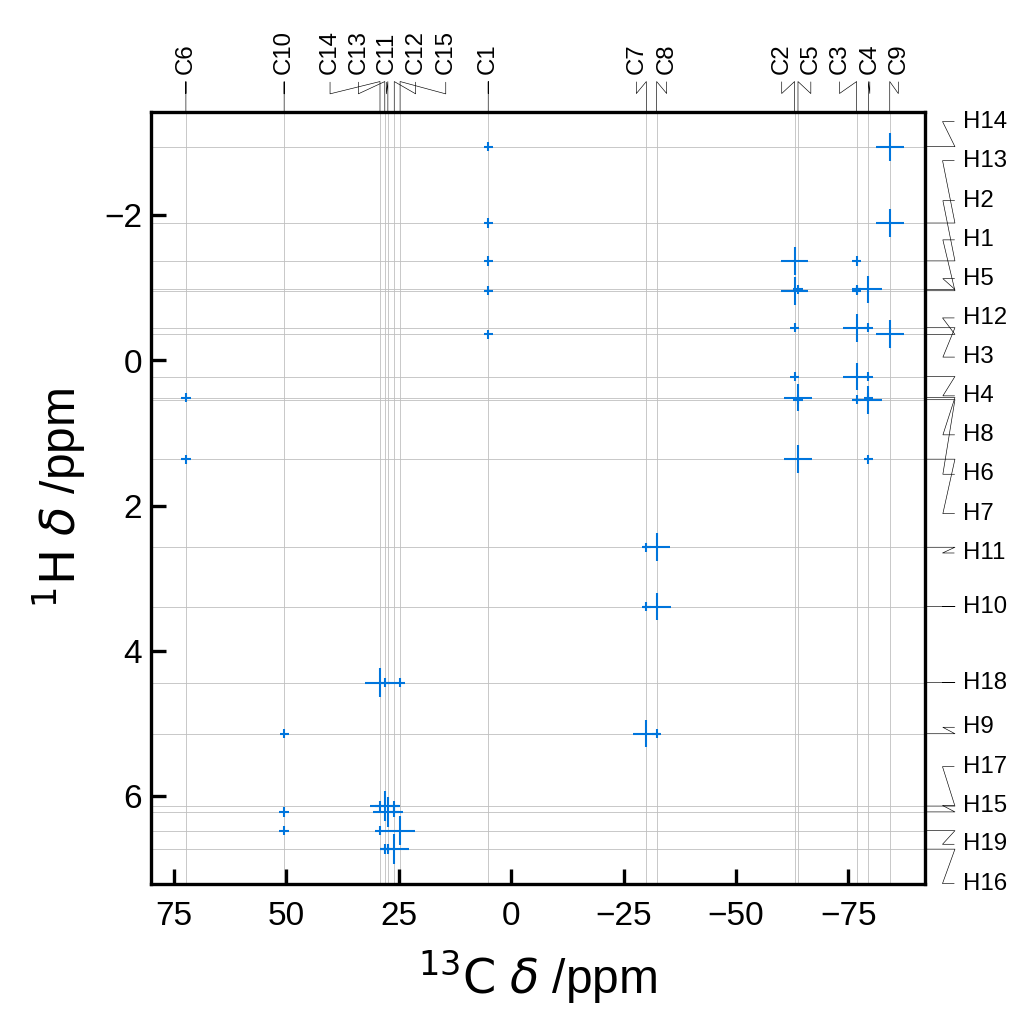

In [5]:
!soprano plotnmr \
    ../tests/test_data/EDIZUM.magres \
    -x C \
    -y H \
    --references C:100,H:30 \
    --scale-marker-by dipolar \
    --rcut 2.5 \
    --no-legend \
    -o ./_temp_output/plot_results.png
Image(filename='_temp_output/plot_results.png')

## Dipolar coupling calculations

We can use the dipolar subcommand to extract dipolar couplings from any structure file (i.e. it need not be a .magres file).

Some example commands are:

```bash
soprano dipolar <structure file>
```

which calculates the dipolar couplings between all pairs of atoms in the structure.

```bash
soprano dipolar <structure file> -i C -j C
```

which calculates the dipolar couplings between all pairs of carbon atoms in the structure.

```bash
soprano dipolar <structure file> -i C1 -j H1
```

which calculates the dipolar couplings between pairs of sites labelled C1 and H1. 

```bash
soprano dipolar <structure file> --rss --cutoff 5.0
```

which calculates the Root Sum Square dipolar constant for each atom in the system up to 5.0 Å away (including periodicity).







In [6]:
# find all C-H couplings with |D| > 10 Hz
!soprano dipolar ./tutorial_data/ethanol.magres \
    -i C -j H \
    --query "abs(D) > 10" \
    -o ./_temp_output/ethanol_dipolar.csv

# Show the results:
df = pd.read_csv('_temp_output/ethanol_dipolar.csv')
df.iloc[:,1:]

Writing output to ./_temp_output/ethanol_dipolar.csv


,pair,label_i,label_j,isotope_i,isotope_j,D/kHz,alpha/deg,beta/deg,file
0,"(0, 6)",H,C,1H,13C,-23.050578,-168.752350,126.182020,./tutorial_data/ethanol.magres
1,"(1, 6)",H,C,1H,13C,-23.004866,-78.545627,59.023572,./tutorial_data/ethanol.magres
2,"(2, 6)",H,C,1H,13C,-23.188447,13.017396,124.957193,./tutorial_data/ethanol.magres
3,"(3, 7)",H,C,1H,13C,-22.733525,-167.901289,55.204961,./tutorial_data/ethanol.magres
4,"(4, 7)",H,C,1H,13C,-23.179595,101.784109,121.180234,./tutorial_data/ethanol.magres


In [7]:
!soprano dipolar ./tutorial_data/ethanol.magres --rss --cutoff 10



Extracted data from: ./tutorial_data/ethanol.magres
   index label isotope  D_RSS/kHz
0      0     H      1H      40221
1      1     H      1H      40496
2      2     H      1H      40030
3      3     H      1H      35389
4      4     H      1H      35029
5      5     H      1H      24082
6      6     C     13C      40313
7      7     C     13C      33251
8      8     O     17O      18061
